In [ ]:
# Taken inspiration from the notebook:- https://www.kaggle.com/code/hechtjp/h-m-eda-rule-base-by-customer-age

In [1]:
# === General ===
import sys, warnings, time, os, copy, gc, re, random, pickle
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.max_columns', None)
# pd.set_option("display.max_colwidth", 10000)
import seaborn as sns
sns.set()
from pandas.io.json import json_normalize
from pprint import pprint
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
from datetime import datetime, timedelta

In [2]:
DEBUG = False

In [3]:
def display_df(df, head=3):
    print(f'The shape of df is {df.shape}.\n')
    display(df.head(head))

In [4]:
article_data = pd.read_csv("../articles.csv", usecols=['article_id', "product_group_name", "perceived_colour_master_name"])
display_df(article_data, head=3)

The shape of df is (105542, 3).



,article_id,product_group_name,perceived_colour_master_name
0,108775015,Garment Upper body,Black
1,108775044,Garment Upper body,White
2,108775051,Garment Upper body,White


In [5]:
customer_data = pd.read_csv("../customers.csv", usecols=['customer_id', 'age'])
display_df(customer_data, head=3)

The shape of df is (1371980, 2).



,customer_id,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0


In [6]:
# customer_data = customer_data.to_pandas()
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
customer_data['age_bins'] = pd.cut(customer_data['age'], listBin)
display_df(customer_data, head=3)

The shape of df is (1371980, 3).



,customer_id,age,age_bins
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,"(39, 49]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,"(19, 29]"
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,"(19, 29]"


In [7]:
x = customer_data[customer_data['age_bins'].isnull()].shape[0]
print(f'{x} customer_id does not have age information.\n')

15861 customer_id does not have age information.



In [8]:
transaction_data = pd.read_csv("../transactions_train.csv", usecols=['t_dat', 'customer_id', 'article_id'],
                               dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'})
transaction_data['t_dat'] = pd.to_datetime(transaction_data['t_dat'])
transaction_data.set_index('t_dat', inplace=True)
display_df(transaction_data, head=3)

The shape of df is (31788324, 2).



,customer_id,article_id
t_dat,,
2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001
2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023
2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004


In [9]:
dfRecent = transaction_data.loc['2020-09-01' : '2020-09-21']
display_df(transaction_data, head=3)

The shape of df is (31788324, 2).



,customer_id,article_id
t_dat,,
2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001
2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023
2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004


In [10]:
# dfRecent = dfRecent.to_pandas()
dfRecent = dfRecent.merge(customer_data[['customer_id', 'age_bins']], on='customer_id', how='inner')
display_df(dfRecent, head=3)

The shape of df is (765403, 3).



,customer_id,article_id,age_bins
0,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,777148006,"(39, 49]"
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,835801001,"(39, 49]"
2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,923134005,"(39, 49]"


In [11]:
dfRecent = dfRecent.groupby(['age_bins', 'article_id']).count().reset_index().rename(columns={'customer_id': 'counts'})

listUniBins = dfRecent['age_bins'].unique().tolist()

dict100 = {}
for uniBin in listUniBins:
    dfTemp = dfRecent[dfRecent['age_bins'] == uniBin]
    dfTemp = dfTemp.sort_values(by='counts', ascending=False)
    dict100[uniBin] = dfTemp.head(100)['article_id'].values.tolist()

df100 = pd.DataFrame([dict100]).T.rename(columns={0:'top100'})

<AxesSubplot:>

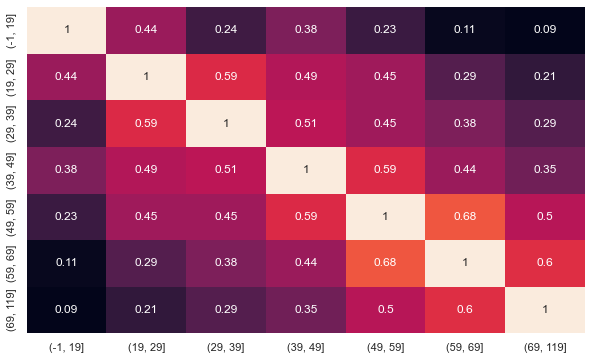

In [12]:
for index in df100.index:
    df100[index] = [len(set(df100.at[index, 'top100']) & set(df100.at[x, 'top100']))/100 for x in df100.index]

df100 = df100.drop(columns='top100')
plt.figure(figsize=(10, 6))
sns.heatmap(df100, annot=True, cbar=False)

In [13]:
N = 12
listUniBins = customer_data['age_bins'].unique().tolist()

In [14]:
for uniBin in listUniBins:
    df  = pd.read_csv("../transactions_train.csv",
                            usecols= ['t_dat', 'customer_id', 'article_id'], 
                            dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'})
    if str(uniBin) == 'nan':
        customer_dataTemp = customer_data[customer_data['age_bins'].isnull()]
    else:
        customer_dataTemp = customer_data[customer_data['age_bins'] == uniBin]
    
    customer_dataTemp = customer_dataTemp.drop(['age_bins'], axis=1)
#     customer_dataTemp = pd.from_pandas(customer_dataTemp)
    
    df = df.merge(customer_dataTemp[['customer_id', 'age']], on='customer_id', how='inner')
    print(f'The shape of scope transaction for {uniBin} is {df.shape}. \n')
          
#     df['customer_id'] = df['customer_id'].str[-16:].astype('str')
#     df['customer_id'] = df['customer_id'].apply(lambda x: int(x, 16)).astype('int64')
    df['t_dat'] = pd.to_datetime(df['t_dat'])
    last_ts = df['t_dat'].max()

#     tmp = df[['t_dat']].copy().to_pandas()
    tmp = df[['t_dat']].copy()
    tmp['dow'] = tmp['t_dat'].dt.dayofweek
    tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')
    tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')

    df['ldbw'] = tmp['ldbw'].values
    
    weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
    weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
    
    df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')
    
    weekly_sales = weekly_sales.reset_index().set_index('article_id')

    df = df.merge(
        weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
        on='article_id', suffixes=("", "_targ"))

    df['count_targ'].fillna(0, inplace=True)
    del weekly_sales
    
    df['quotient'] = df['count_targ'] / df['count']
    
    target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
#     general_pred = target_sales.nlargest(N).index.to_pandas().tolist()
    general_pred = target_sales.nlargest(N).index.tolist()
    general_pred = ['0' + str(article_id) for article_id in general_pred]
    general_pred_str =  ' '.join(general_pred)
    del target_sales
    
    purchase_dict = {}

#     tmp = df.copy().to_pandas()
    tmp = df.copy()
    tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
    tmp['dummy_1'] = 1 
    tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

    a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
    tmp['y'] = a / np.sqrt(tmp['x']) + b * np.exp(-c*tmp['x']) - d

    tmp['dummy_0'] = 0 
    tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
    tmp['value'] = tmp['quotient'] * tmp['y'] 

    tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
    tmp = tmp.reset_index()

    tmp = tmp.loc[tmp['value'] > 0]
    tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
    tmp = tmp.loc[tmp['rank'] <= 12]

    purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
    purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
    purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
    purchase_df['prediction'] = purchase_df['prediction'].str.strip()
    purchase_df = pd.DataFrame(purchase_df)
    
    sub  = pd.read_csv("../sample_submission.csv",
                            usecols= ['customer_id'], 
                            dtype={'customer_id': 'string'})
    
    numCustomers = sub.shape[0]
    
    sub = pd.merge(sub, customer_dataTemp[['customer_id', 'age']], on='customer_id', how='inner')

#     sub['customer_id2'] = sub['customer_id'].str[-16:].astype('str')
#     sub['customer_id2'] = sub['customer_id2'].apply(lambda x: int(x, 16)).astype('int64')

    sub = pd.merge(sub, purchase_df, left_on = 'customer_id', right_on = 'customer_id', how = 'left',
                   suffixes = ('', '_ignored'))

#     sub = sub.to_pandas()
    sub['prediction'] = sub['prediction'].fillna(general_pred_str)
    sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str
    sub['prediction'] = sub['prediction'].str.strip()
    sub['prediction'] = sub['prediction'].str[:131]
    sub = sub[['customer_id', 'prediction']]
    sub.to_csv(f'submission_' + str(uniBin) + '.csv',index=False)
    print(f'Saved prediction for {uniBin}. The shape is {sub.shape}. \n')
    print('-'*50)
    
print('Finished.\n')
print('='*50)

The shape of scope transaction for (39.0, 49.0] is (4908363, 4). 

Saved prediction for (39.0, 49.0]. The shape is (204118, 2). 

--------------------------------------------------
The shape of scope transaction for (19.0, 29.0] is (13058587, 4). 

Saved prediction for (19.0, 29.0]. The shape is (528358, 2). 

--------------------------------------------------
The shape of scope transaction for (49.0, 59.0] is (5136958, 4). 

Saved prediction for (49.0, 59.0]. The shape is (226242, 2). 

--------------------------------------------------
The shape of scope transaction for nan is (140258, 4). 

Saved prediction for nan. The shape is (15861, 2). 

--------------------------------------------------
The shape of scope transaction for (29.0, 39.0] is (6428863, 4). 

Saved prediction for (29.0, 39.0]. The shape is (234068, 2). 

--------------------------------------------------
The shape of scope transaction for (69.0, 119.0] is (220067, 4). 

Saved prediction for (69.0, 119.0]. The shape i

In [15]:
for i, uniBin in enumerate(listUniBins):
    dfTemp  = pd.read_csv(f"../submission_" + str(uniBin) + ".csv")
    if i == 0:
        dfSub = dfTemp
    else:
        dfSub = pd.concat([dfSub, dfTemp], axis=0)

assert dfSub.shape[0] == numCustomers, f'The number of dfSub rows is not correct. {dfSub.shape[0]} vs {numCustomers}.'

dfSub.to_csv(f"../submission.csv", index=False)
print(f"Saved submission.csv.")

Saved submission.csv.


In [16]:
dfCheck = pd.read_csv("../submission.csv")
display_df(dfCheck, head=3)

The shape of df is (1371980, 2).



,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601006 0745232001 0751471001 04...
1,00009c2aeae8761f738e4f937d9be6b49861a66339c2b1...,0857690004 0841793002 0751471001 0448509014 05...
2,0000b95f630aaa9313028ce9c41154bb95ac7afa34f55b...,0751471001 0448509014 0579541001 0706016001 06...


In [20]:
df100 

,"(-1, 19]","(19, 29]","(29, 39]","(39, 49]","(49, 59]","(59, 69]","(69, 119]"
"(-1, 19]",1.00,0.44,0.24,0.38,0.23,0.11,0.09
"(19, 29]",0.44,1.00,0.59,0.49,0.45,0.29,0.21
"(29, 39]",0.24,0.59,1.00,0.51,0.45,0.38,0.29
"(39, 49]",0.38,0.49,0.51,1.00,0.59,0.44,0.35
"(49, 59]",0.23,0.45,0.45,0.59,1.00,0.68,0.50
"(59, 69]",0.11,0.29,0.38,0.44,0.68,1.00,0.60
"(69, 119]",0.09,0.21,0.29,0.35,0.50,0.60,1.00
